In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

d:\Users\hanklee\anaconda3\envs\sst\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
0


# DATA

In [5]:
df=pd.read_csv('Financial Sentiment Analysis.csv')

In [6]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [9]:
# 將資料類別編碼
df['Sentiment'] = df['Sentiment'].map({'negative': 0, 'positive': 1})

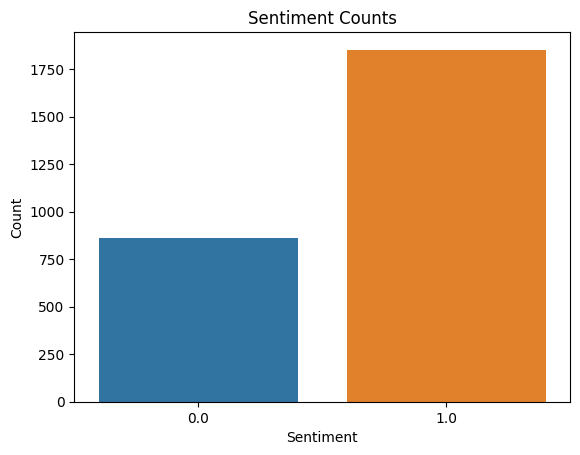

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# 統計0和1的次數
sentiment_counts = df['Sentiment'].value_counts()

# 繪製次數長條圖
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# 設置圖表標題和標籤
plt.title('情感次數')
plt.xlabel('情感')
plt.ylabel('次數')

# 顯示圖表
plt.show()

#　MODEL

In [12]:
import pandas as pd
import time
import torch
from simpletransformers.classification import ClassificationModel, ClassificationArgs

def train():
    tStartTrain = time.time()

    train_data = []

    train_aidea_csv = pd.read_csv('Financial Sentiment Analysis.csv', escapechar='\\', header=None)
    list_dataset_train_aidea = train_aidea_csv.values.tolist()

    # 將類別編碼為 0 和 1
    train_data = [[dataset[0], 1 if dataset[1] == "positive" else 0] for dataset in list_dataset_train_aidea]

    # 將資料拆分為訓練、測試
    random.shuffle(train_data)
    middle = int(len(train_data) * 0.7)
    list_train = train_data[:middle]
    list_eval = train_data[middle:]

    # 模型選擇與超參數設定
    model_name_main = 'roberta-base'
    batch_size = 48
    epoch = 20
    output_dir = f"outputs/{model_name_main}-bs-{batch_size}-ep-{epoch}-cls-model/"

    model_args = ClassificationArgs()
    model_args.train_batch_size = batch_size
    model_args.num_train_epochs = epoch
    model_args.overwrite_output_dir = True
    model_args.reprocess_input_data = True
    model_args.use_multiprocessing = True
    model_args.save_model_every_epoch = False
    model_args.save_steps = -1
    model_args.learning_rate = 4e-5
    model_args.output_dir = output_dir

    model_args.use_early_stopping = True
    model_args.evaluate_during_training = False
    model_args.eval_batch_size = batch_size
    model_args.use_multiprocessing_for_evaluation = True
    model_args.evaluate_during_training_steps = 500

    model = ClassificationModel(
        'roberta',
        model_name_main,
        use_cuda=torch.cuda.is_available(),
        cuda_device=0,
        num_labels=2,
        args=model_args
    )
    # 將LIST轉為DATAFRAME
    train_df = pd.DataFrame(list_train, columns=["text", "labels"])
    eval_df = pd.DataFrame(list_eval, columns=["text", "labels"])
    # 調整類別權重(因原生DATA類別不平衡 加強少數類別學習)
    label_counts = train_df['labels'].value_counts().to_dict()
    total_samples = train_df.shape[0]
    class_weights = {label: total_samples / count for label, count in label_counts.items()}

    model_args.class_weight = class_weights

    model.train_model(train_df, eval_df=eval_df, class_weights=class_weights)
    # 訓練及驗證花費時間
    tEndTrain = time.time()
    print("[Train] It took %f sec" % (tEndTrain - tStartTrain))

    tStartEval = time.time()

    result, model_outputs, wrong_predictions = model.eval_model(eval_df)
    print(f"result: {result}, model_outputs: {model_outputs}, wrong_predictions: {wrong_predictions}")

    tEndEval = time.time()
    print("[Evaluation] It took %f sec" % (tEndEval - tStartEval))

if __name__ == "__main__":
    train()


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

[Train] It took 2957.025971 sec


Running Evaluation: 100%|██████████| 37/37 [00:15<00:00,  2.43it/s]

result: {'mcc': 0.8464187930882822, 'eval_loss': 0.5431285639469688}, model_outputs: [[ 1.98242188  8.46875    -2.12890625 ... -1.90039062 -1.97363281
  -2.03320312]
 [ 8.6015625   2.65234375 -2.12890625 ... -2.1875     -2.6484375
  -2.3359375 ]
 [-1.43457031  9.4921875  -1.65136719 ... -1.35351562 -1.37597656
  -1.68359375]
 ...
 [ 9.6796875  -0.72167969 -1.70117188 ... -1.89453125 -2.359375
  -1.95703125]
 [ 9.640625   -1.55273438 -1.59667969 ... -1.70507812 -2.21289062
  -1.83886719]
 [ 9.65625    -1.35644531 -1.63085938 ... -1.77636719 -2.24804688
  -1.87304688]], wrong_predictions: [{'guid': 0, 'text_a': "Sainsbury's, Asda, Tesco and Morrisons will all cut petrol prices as oil falls ...", 'text_b': None, 'label': 0}, {'guid': 31, 'text_a': "$IMRS - it's important to be pragmatic in analysis...high prices could offer head-winds....bullish story intact,evenif the market rolls over", 'text_b': None, 'label': 1}, {'guid': 70, 'text_a': "$FB churning in high volume @ IPO price. Lot's o